In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import IsolationForest
import seaborn as sns

In [2]:
file_path = 'Np_MacPherson_Merged_Tank_Data.csv'
df = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
df.head()


,Unnamed: 0,devicename,deviceid,hourly_interval,Soil - EC,Soil - Moisture,Soil - Nitrogen,Soil - PH,Soil - Phosphorus,Soil - Potassium,Soil - Temperature,feed,pH of Worm Feed
0,0,NDS004,7.0,2024-07-18 12:00:00,17.000000,11.000000,0.000000,3.300000,0.000000,0.000000,29.1,15g egg carton cardboard,NaN
1,1,NDS004,7.0,2024-07-18 12:10:00,8.833333,21.216667,67.833333,3.433333,0.000000,129.500000,29.11666666666667,15g egg carton cardboard,NaN
2,2,NDS004,7.0,2024-07-19 05:30:00,24.000000,11.850000,0.000000,7.000000,0.000000,0.000000,29.1,NaN,NaN
3,3,NDS004,7.0,2024-07-19 05:40:00,6.000000,11.200000,114.250000,1.750000,0.000000,194.250000,29.125,NaN,NaN
4,4,NDS004,7.0,2024-07-22 04:30:00,77.307692,10.500000,137.307692,6.915385,176.538462,215.769231,30.861538461538466,7.5g egg carton cardboard,NaN


In [3]:
# Drop the specified columns
df.drop(columns=['pH of Worm Feed', 'devicename', 'deviceid'], inplace=True)
df.head()

,Unnamed: 0,hourly_interval,Soil - EC,Soil - Moisture,Soil - Nitrogen,Soil - PH,Soil - Phosphorus,Soil - Potassium,Soil - Temperature,feed
0,0,2024-07-18 12:00:00,17.000000,11.000000,0.000000,3.300000,0.000000,0.000000,29.1,15g egg carton cardboard
1,1,2024-07-18 12:10:00,8.833333,21.216667,67.833333,3.433333,0.000000,129.500000,29.11666666666667,15g egg carton cardboard
2,2,2024-07-19 05:30:00,24.000000,11.850000,0.000000,7.000000,0.000000,0.000000,29.1,NaN
3,3,2024-07-19 05:40:00,6.000000,11.200000,114.250000,1.750000,0.000000,194.250000,29.125,NaN
4,4,2024-07-22 04:30:00,77.307692,10.500000,137.307692,6.915385,176.538462,215.769231,30.861538461538466,7.5g egg carton cardboard


In [4]:
# Drop rows where Soil - Nitrogen, Soil - Potassium, and Soil - Phosphorus are all 0 or null
df = df[~((df['Soil - Nitrogen'].fillna(0) == 0) & (df['Soil - Potassium'].fillna(0) == 0) & (df['Soil - Phosphorus'].fillna(0) == 0))]

In [5]:
# Update the Soil - Moisture column to binary values
df.loc[:3203, 'Soil - Moisture'] = df.loc[:3203, 'Soil - Moisture'].apply(lambda x: 0 if x < 20 else 1)

In [6]:
# Replace all null values in the Soil - Moisture column with 0.0
df['Soil - Moisture'].fillna(0.0, inplace=True)

In [7]:
# Define the conversion function
def mv_to_ph(mv):
    return 7 + (mv / 59.16)

# Apply the conversion function to rows beyond 3204
df.loc[3204:, 'Soil - PH'] = df.loc[3204:, 'Soil - PH'].apply(mv_to_ph)

In [8]:
# Calculate the average Soil - PH value
average_ph = df['Soil - PH'].mean()

# Replace missing values in the Soil - PH column with the average
df['Soil - PH'].fillna(average_ph, inplace=True)

In [9]:
# Calculate the average Soil - EC value
average_ec = df['Soil - EC'].mean()

# Replace missing values in the Soil - EC column with the average
df['Soil - EC'].fillna(average_ec, inplace=True)

In [10]:
# Perform forward interpolation for the 'feed' column
df['feed'].interpolate(method='pad', inplace=True)

C:\Users\huohe\AppData\Local\Temp\ipykernel_17404\2733079976.py:2: FutureWarning: Series.interpolate with method=pad is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['feed'].interpolate(method='pad', inplace=True)


In [11]:
columns_to_drop = ["Unnamed: 0","hourly_interval"]
df.drop(columns=columns_to_drop, inplace=True)

In [12]:
# Drop rows where Soil - Moisture is not 1.0 or 0.0
df = df[(df['Soil - Moisture'] == 1.0) | (df['Soil - Moisture'] == 0.0)]

In [13]:
df.head()

,Soil - EC,Soil - Moisture,Soil - Nitrogen,Soil - PH,Soil - Phosphorus,Soil - Potassium,Soil - Temperature,feed
1,8.833333,1.0,67.833333,3.433333,0.000000,129.500000,29.11666666666667,15g egg carton cardboard
3,6.000000,0.0,114.250000,1.750000,0.000000,194.250000,29.125,15g egg carton cardboard
4,77.307692,0.0,137.307692,6.915385,176.538462,215.769231,30.861538461538466,7.5g egg carton cardboard
5,29.842105,0.0,59.210526,5.084211,80.526316,81.578947,36.12105263157895,7.5g egg carton cardboard
9,82.857143,0.0,145.714286,6.935714,182.142857,218.571429,32.66428571428572,7.5g egg carton cardboard


In [14]:
df.describe()

,Soil - EC,Soil - Moisture,Soil - Nitrogen,Soil - PH,Soil - Phosphorus,Soil - Potassium
count,7586.000000,7586.000000,7452.000000,7586.000000,7586.000000,7452.000000
mean,174.180603,0.822568,85.945227,7.255626,105.230882,95.758730
std,29.406336,0.382059,71.952242,1.208893,61.785746,58.768785
min,6.000000,0.000000,-335.000000,1.425000,-335.000000,-335.000000
25%,172.980718,1.000000,12.000000,6.974645,40.648684,34.000000
50%,172.980718,1.000000,118.500000,7.242916,141.000000,97.000000
75%,172.980718,1.000000,148.500000,7.242916,155.000000,146.000000
max,418.210526,1.000000,200.500000,10.467377,212.736842,229.631579


In [15]:
# Check for missing values
missing_values = df.isnull().sum()
missing_values

Soil - EC               0
Soil - Moisture         0
Soil - Nitrogen       134
Soil - PH               0
Soil - Phosphorus       0
Soil - Potassium      134
Soil - Temperature    263
feed                    0
dtype: int64

In [16]:
# Check for duplicates
duplicates = df.duplicated().sum()
duplicates

2521

In [17]:
# Drop duplicates directly on the dataframe
df.drop_duplicates(inplace=True)
# Convert the Soil - Temperature column to numeric, coercing errors to NaN
df['Soil - Temperature'] = pd.to_numeric(df['Soil - Temperature'], errors='coerce')

# Fill missing values with the column average directly on the dataframe
df['Soil - Nitrogen'].fillna(df['Soil - Nitrogen'].mean(), inplace=True)
df['Soil - Potassium'].fillna(df['Soil - Potassium'].mean(), inplace=True)
df['Soil - Temperature'].fillna(df['Soil - Temperature'].mean(), inplace=True)


C:\Users\huohe\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\huohe\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\huohe\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\huohe\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

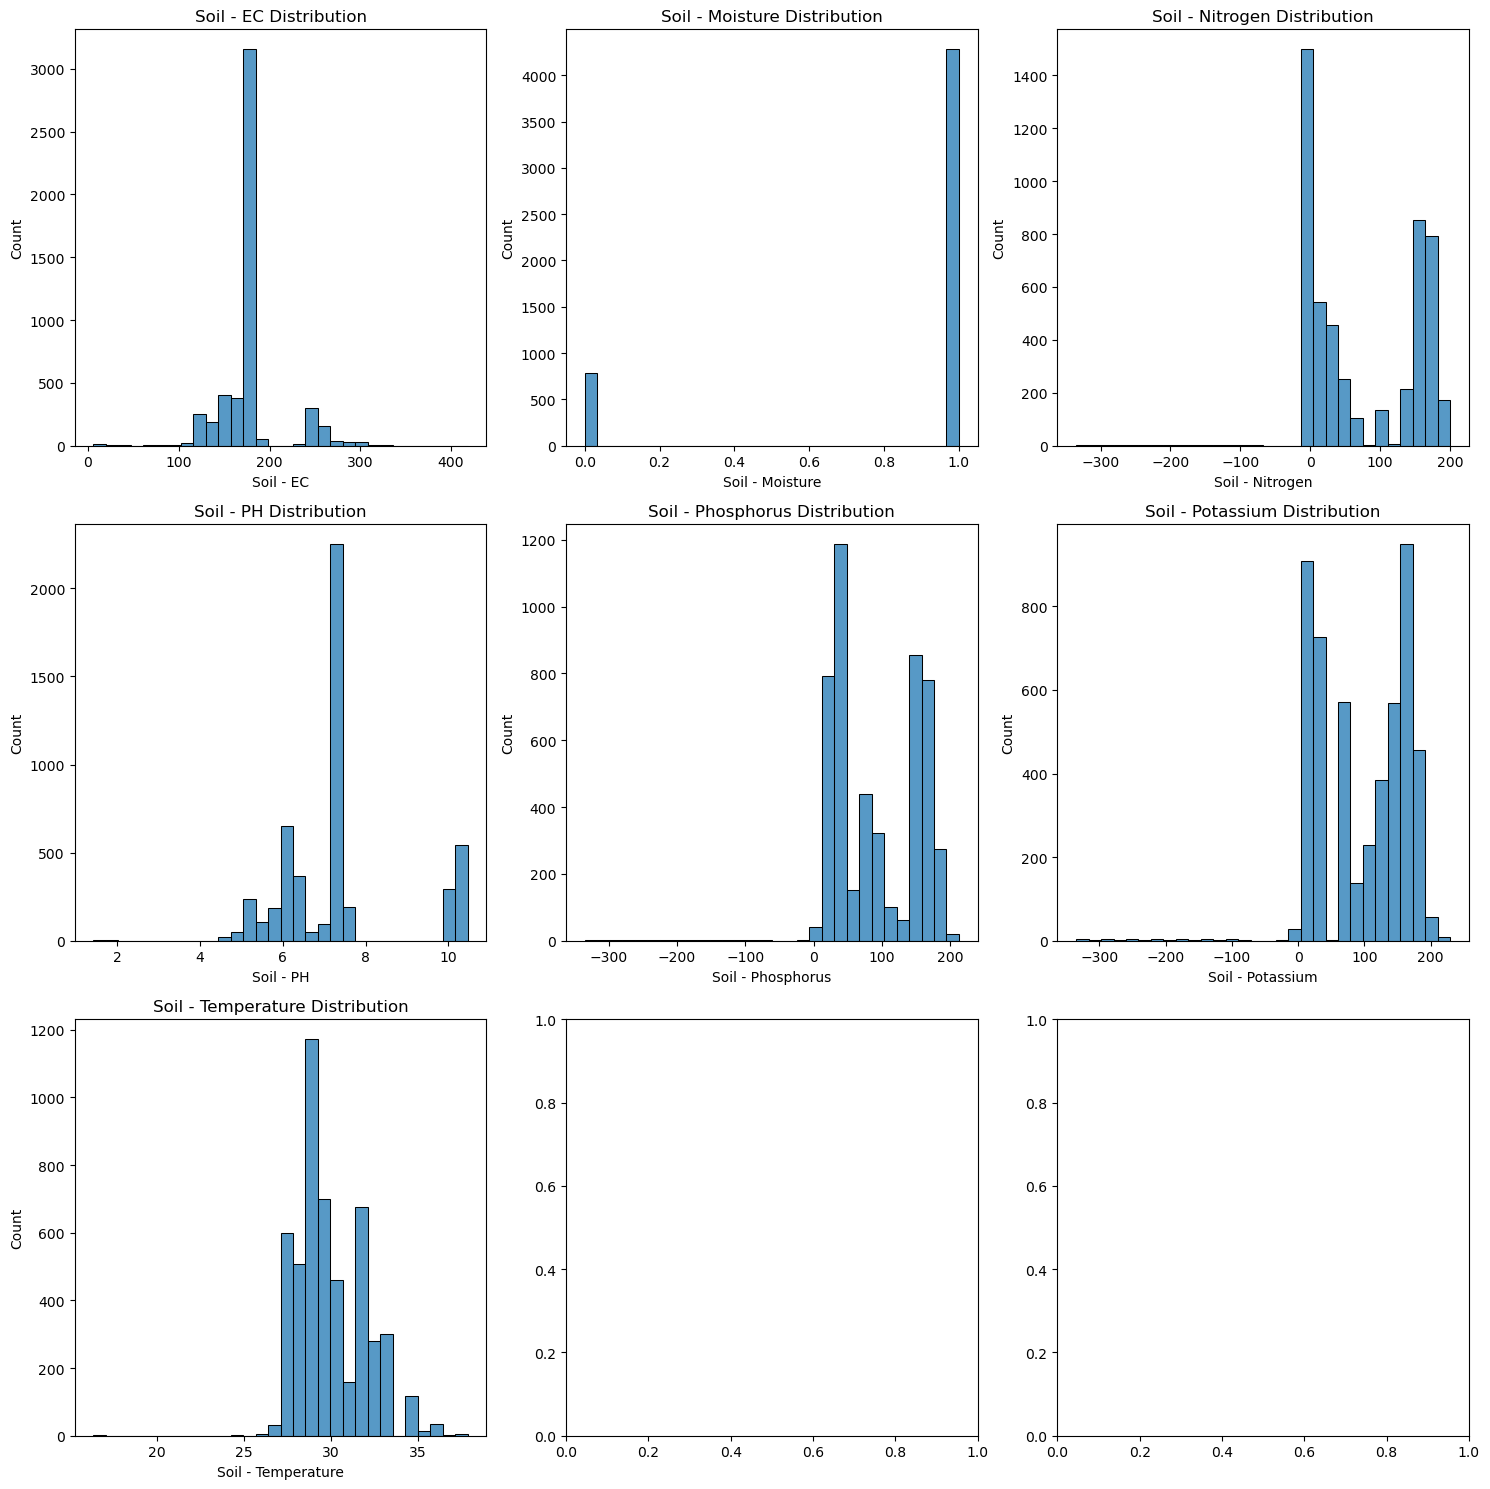

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(3, 3, figsize=(15, 15))
sns.histplot(df['Soil - EC'], bins=30, ax=axs[0, 0]).set_title('Soil - EC Distribution')
sns.histplot(df['Soil - Moisture'], bins=30, ax=axs[0, 1]).set_title('Soil - Moisture Distribution')
sns.histplot(df['Soil - Nitrogen'], bins=30, ax=axs[0, 2]).set_title('Soil - Nitrogen Distribution')
sns.histplot(df['Soil - PH'], bins=30, ax=axs[1, 0]).set_title('Soil - PH Distribution')
sns.histplot(df['Soil - Phosphorus'], bins=30, ax=axs[1, 1]).set_title('Soil - Phosphorus Distribution')
sns.histplot(df['Soil - Potassium'], bins=30, ax=axs[1, 2]).set_title('Soil - Potassium Distribution')
sns.histplot(df['Soil - Temperature'], bins=30, ax=axs[2, 0]).set_title('Soil - Temperature Distribution')

plt.tight_layout()
plt.show()


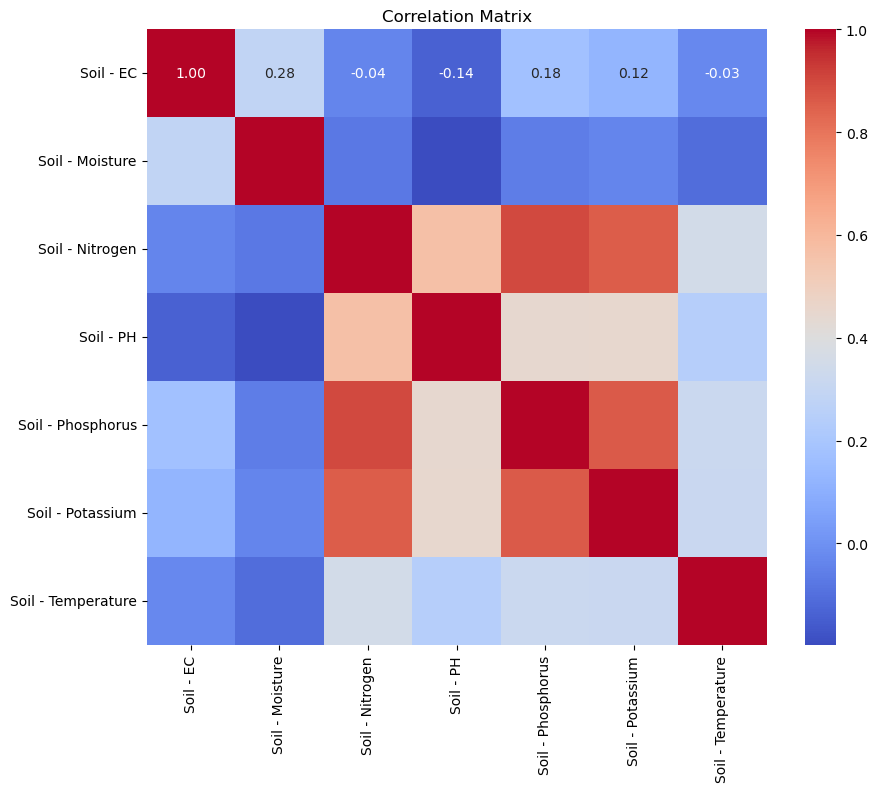

In [19]:
# Correlation Heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr(numeric_only=True)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f").set_title('Correlation Matrix')
plt.show()

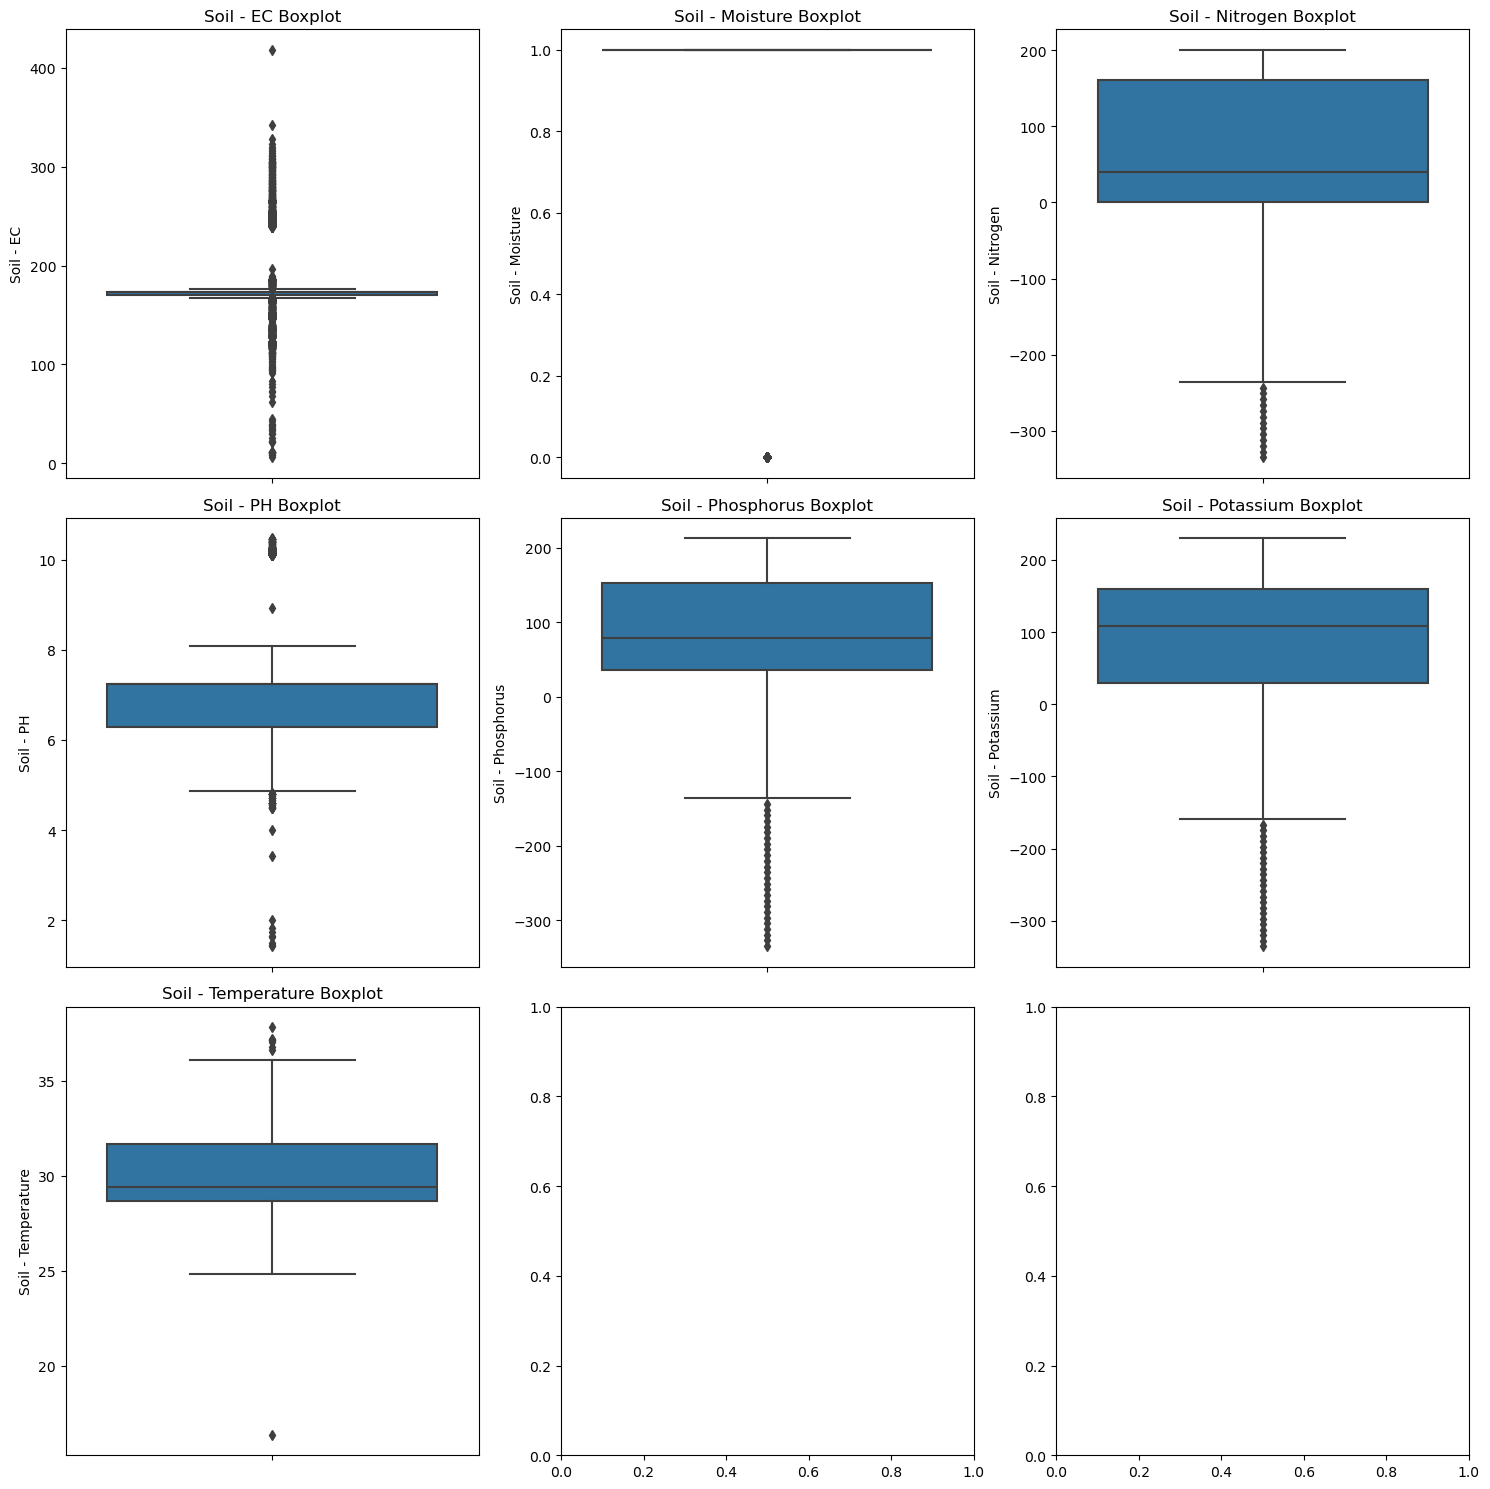

In [20]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
sns.boxplot(y=df['Soil - EC'], ax=axs[0, 0]).set_title('Soil - EC Boxplot')
sns.boxplot(y=df['Soil - Moisture'], ax=axs[0, 1]).set_title('Soil - Moisture Boxplot')
sns.boxplot(y=df['Soil - Nitrogen'], ax=axs[0, 2]).set_title('Soil - Nitrogen Boxplot')
sns.boxplot(y=df['Soil - PH'], ax=axs[1, 0]).set_title('Soil - PH Boxplot')
sns.boxplot(y=df['Soil - Phosphorus'], ax=axs[1, 1]).set_title('Soil - Phosphorus Boxplot')
sns.boxplot(y=df['Soil - Potassium'], ax=axs[1, 2]).set_title('Soil - Potassium Boxplot')
sns.boxplot(y=df['Soil - Temperature'], ax=axs[2, 0]).set_title('Soil - Temperature Boxplot')

plt.tight_layout()
plt.show()

In [21]:
# Remove outliers from Soil - Temperature using the IQR method
Q1 = df['Soil - Temperature'].quantile(0.25)
Q3 = df['Soil - Temperature'].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the dataframe
df = df[(df['Soil - Temperature'] >= lower_bound) & (df['Soil - Temperature'] <= upper_bound)]

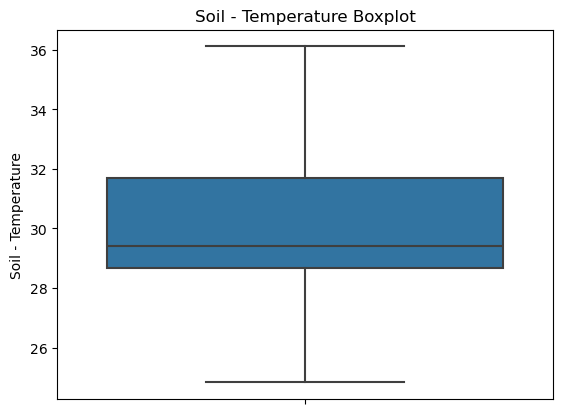

In [22]:
sns.boxplot(y=df['Soil - Temperature']).set_title('Soil - Temperature Boxplot')
plt.show()

In [23]:
# Remove extreme outliers from Soil - EC using the IQR method
Q1_EC = df['Soil - EC'].quantile(0.25)
Q3_EC = df['Soil - EC'].quantile(0.75)
IQR_EC = Q3_EC - Q1_EC

# Define lower and upper bounds for extreme outliers
lower_bound_EC = Q1_EC - 2 * IQR_EC
upper_bound_EC = Q3_EC + 2 * IQR_EC

# Filter the dataframe
df = df[(df['Soil - EC'] >= lower_bound_EC) & (df['Soil - EC'] <= upper_bound_EC)]


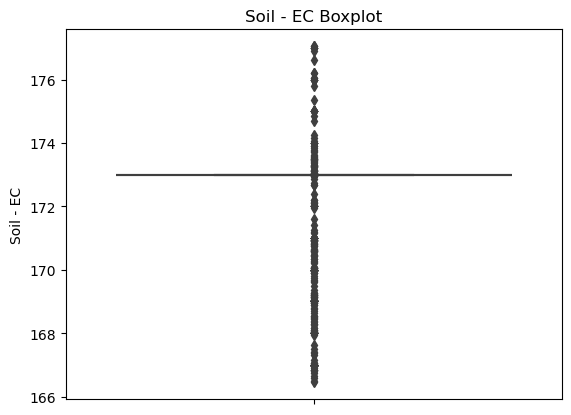

In [24]:
sns.boxplot(y=df['Soil - EC']).set_title('Soil - EC Boxplot')
plt.show()

In [25]:
# Step 1: Get unique categories
unique_categories = df['feed'].unique()

# Step 2: Create binary columns
for category in unique_categories:
    df[f'feed_{category}'] = df['feed'].apply(lambda x: 1 if x == category else 0)

# Display the first few rows of the dataframe to confirm
df.head()

# Save the aggregated dataframe to a new Excel file
output_path = 'Encoded_Cleaned_Time.xlsx'
df.to_excel(output_path, index=False)

In [26]:
df.tail()

,Soil - EC,Soil - Moisture,Soil - Nitrogen,Soil - PH,Soil - Phosphorus,Soil - Potassium,Soil - Temperature,feed,feed_7.5g egg carton cardboard,feed_7.5g egg shell,feed_15g coffee grinds,"feed_7.5g coffee grinds, 15g egg carton cardboard","feed_15g coffee grounds, 100g of distilled water, 3 spoons of coffee grounds",feed_20g of cardboard,feed_40g of distilled water
12902,172.980718,1.0,35.0,7.242916,53.5,173.5,27.8,40g of distilled water,0,0,0,0,0,0,1
12903,172.980718,1.0,31.0,7.242916,54.0,173.5,27.7,40g of distilled water,0,0,0,0,0,0,1
12904,172.980718,1.0,34.5,7.242916,55.0,174.0,27.3,40g of distilled water,0,0,0,0,0,0,1
12905,172.980718,1.0,33.5,7.242916,55.0,174.0,27.9,40g of distilled water,0,0,0,0,0,0,1
12906,172.980718,1.0,30.5,7.242916,55.0,174.0,27.0,40g of distilled water,0,0,0,0,0,0,1


In [27]:
data_cleaned = df.copy()

In [28]:
data_cleaned.drop(columns = ["feed"],inplace = True)

In [29]:
# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_cleaned)

In [30]:
# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_cleaned)

C:\Users\huohe\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\huohe\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\huohe\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\huohe\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\huohe\anaconda3\Lib\site-packages\sklearn\clust

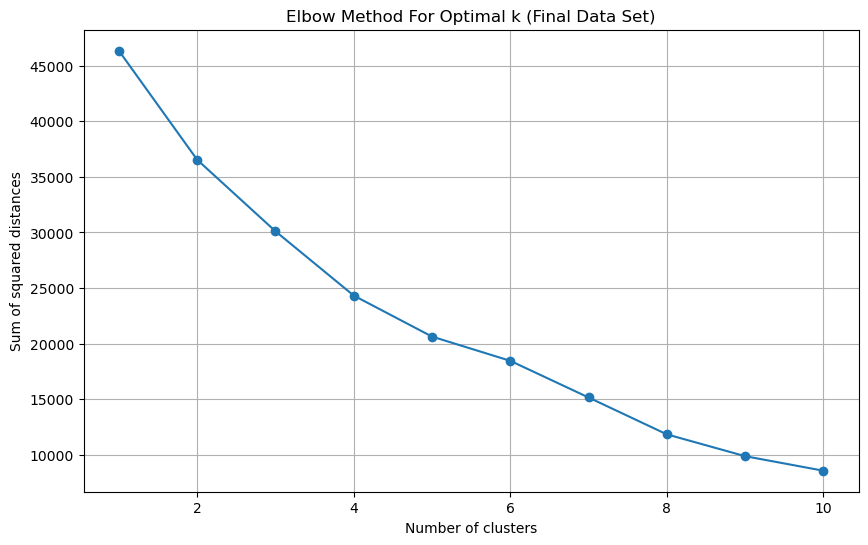

In [31]:
# Determine the optimal number of clusters using the elbow method for the adjusted dataset
inertia_final = []
k_range_final = range(1, 11)

for k in k_range_final:
    kmeans_final = KMeans(n_clusters=k, random_state=42)
    kmeans_final.fit(data_scaled)
    inertia_final.append(kmeans_final.inertia_)

# Plot the elbow curve for the final dataset
plt.figure(figsize=(10, 6))
plt.plot(k_range_final, inertia_final, marker='o')
plt.title('Elbow Method For Optimal k (Final Data Set)')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.grid(True)
plt.show()


In [32]:
# Perform K-means clustering with 4 clusters
kmeans_optimal = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans_optimal.fit_predict(data_scaled)

# Add cluster labels to the normalized data
data_cleaned['Cluster'] = cluster_labels

# Calculate the mean of each feature within each cluster
cluster_characteristics = data_cleaned.groupby('Cluster').mean()

C:\Users\huohe\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [33]:
# Initialize and fit the K-means model
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(data_scaled)

# Predict the cluster labels
y_pred = kmeans.predict(data_scaled)

# Retrieve the cluster labels directly from the model
labels = kmeans.labels_

# Calculate the silhouette score using the Euclidean metric
silhouette = silhouette_score(data_scaled, labels, metric='manhattan')

# Print the silhouette score
print('Silhouette Score: {:.3f}'.format(silhouette))

C:\Users\huohe\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score: 0.533


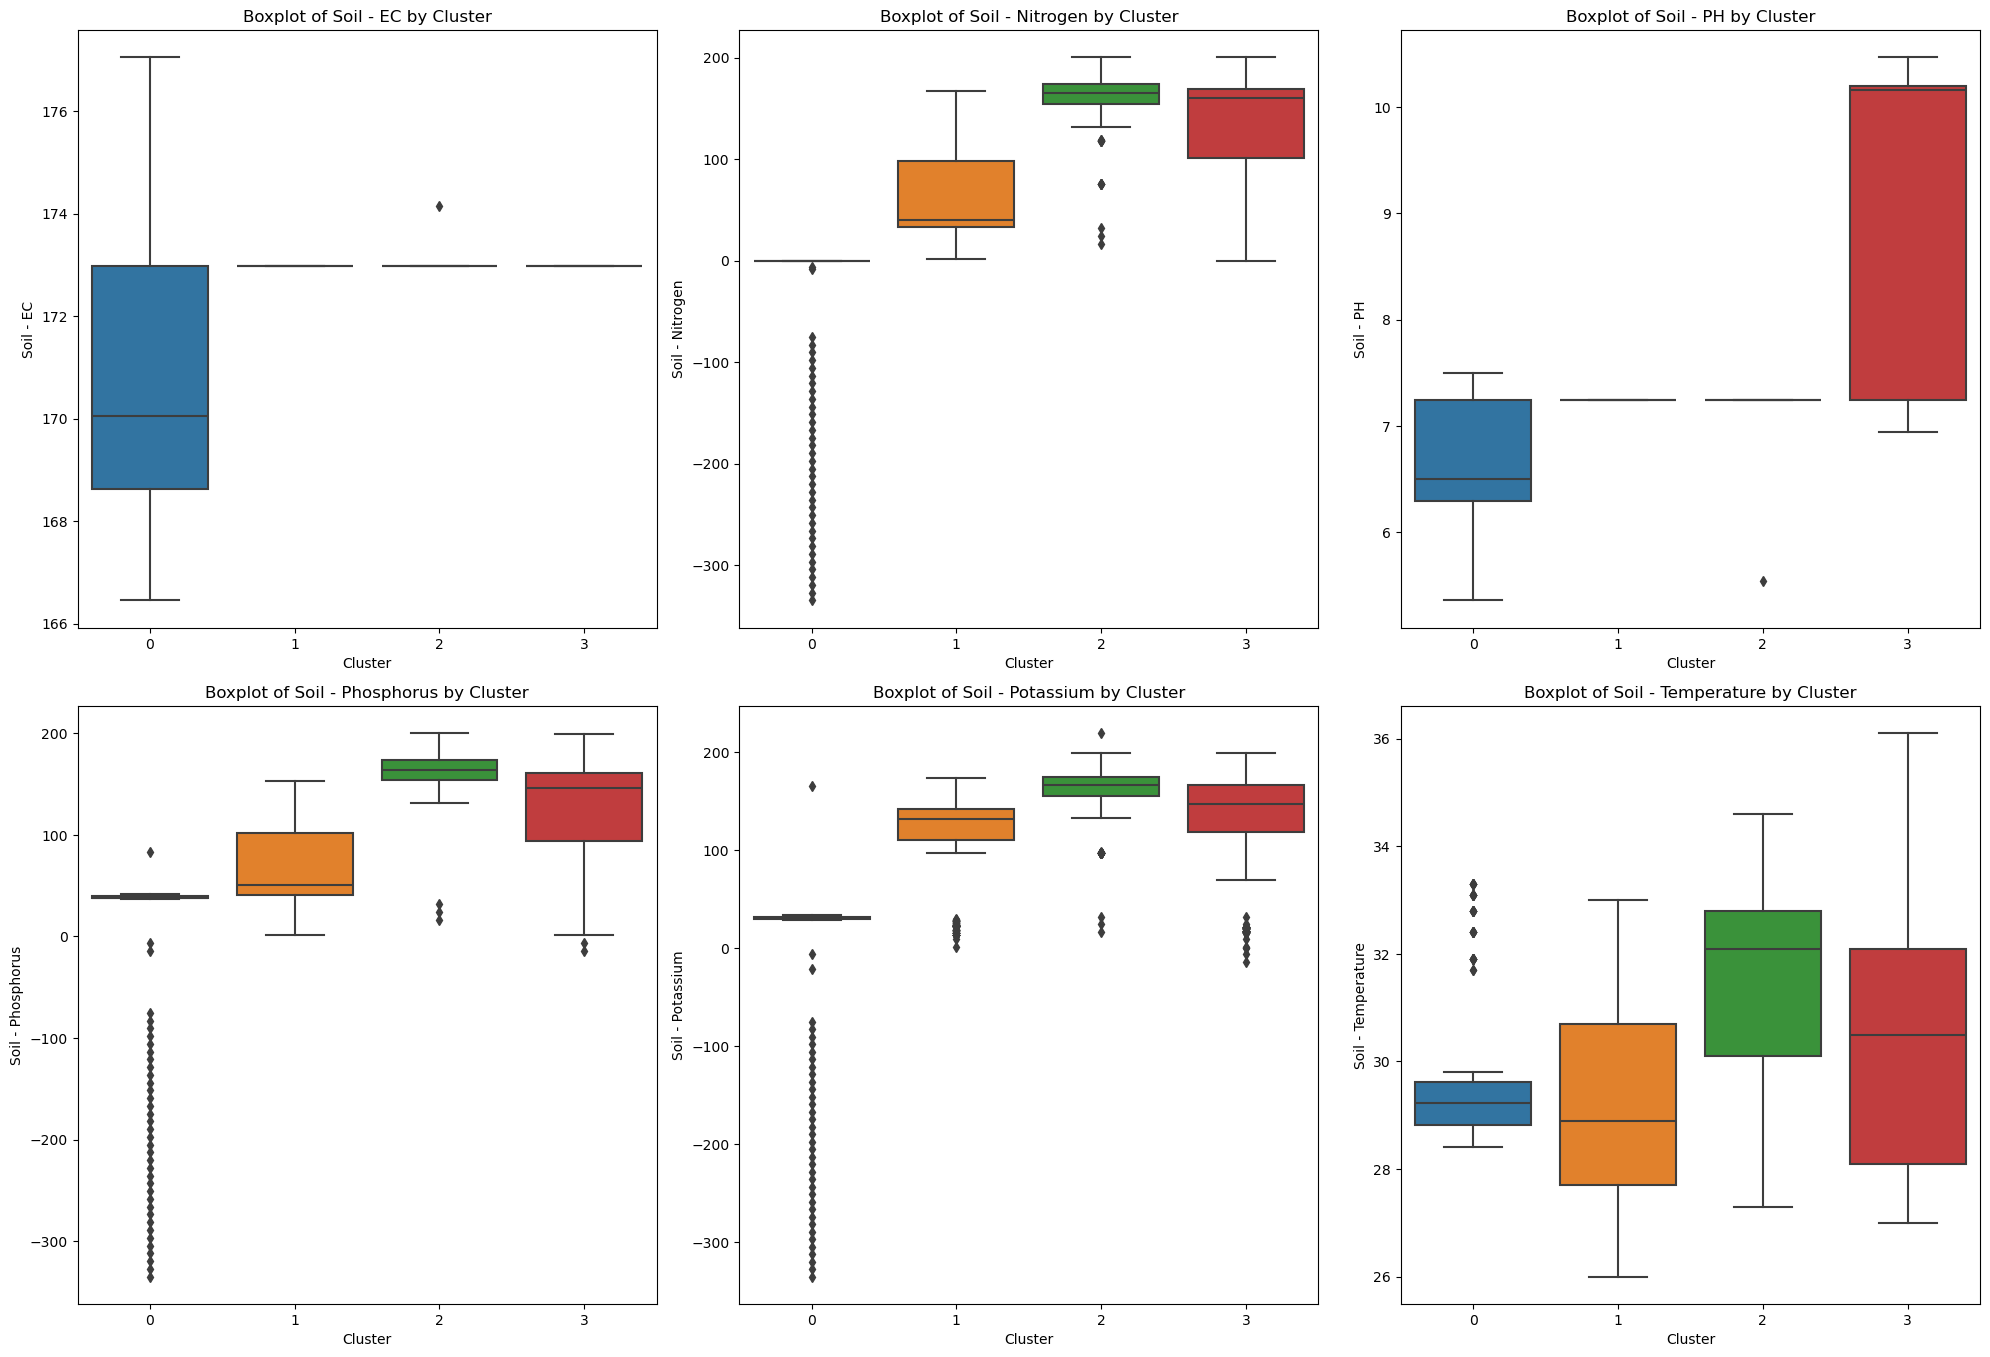

In [36]:
# Set up the matplotlib figure for boxplots
plt.figure(figsize=(20, 20))

# Calculate the number of rows needed for the subplots
num_features = data_cleaned.shape[1] - 1 - 7  # Exclude the last 7 features
num_cols = 3
num_rows = (num_features + num_cols - 1) // num_cols

# Exclude 'Moisture' from the columns to be plotted
columns_to_plot = [col for col in data_cleaned.columns[:-8] if col != 'Soil - Moisture']

# Create a boxplot for each feature by cluster, excluding 'Moisture' and the last 7 features
for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.boxplot(x='Cluster', y=column, data=data_cleaned)
    plt.title(f'Boxplot of {column} by Cluster')

plt.tight_layout()
plt.show()


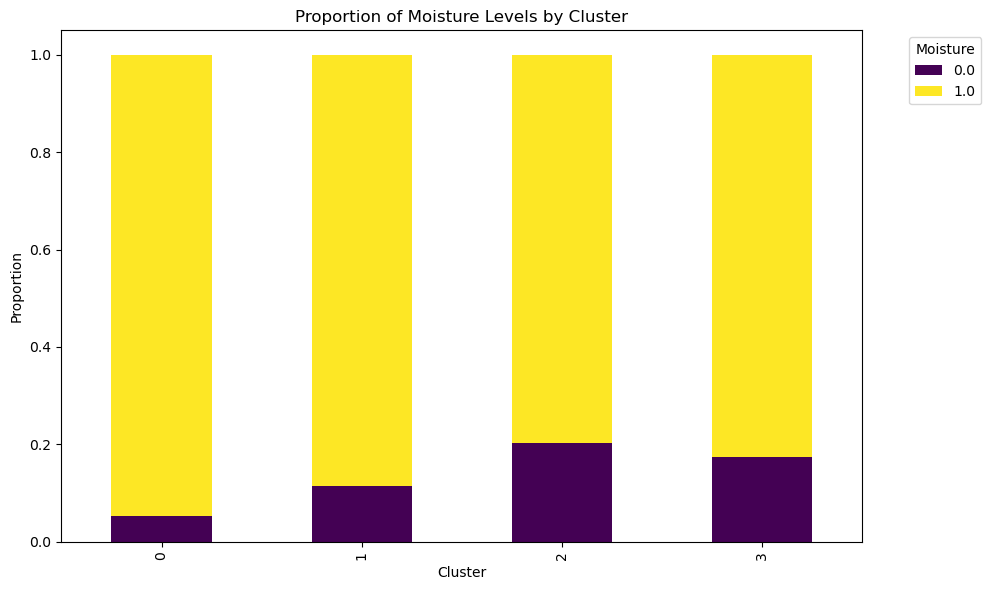

In [37]:
# Calculate the proportion of each moisture level within each cluster
moisture_proportions = data_cleaned.groupby('Cluster')['Soil - Moisture'].value_counts(normalize=True).unstack()

# Plot the proportion of moisture levels within each cluster
moisture_proportions.plot(kind='bar', stacked=True, figsize=(10, 6), cmap='viridis')
plt.title('Proportion of Moisture Levels by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Proportion')
plt.legend(title='Moisture', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


<Figure size 1200x600 with 0 Axes>

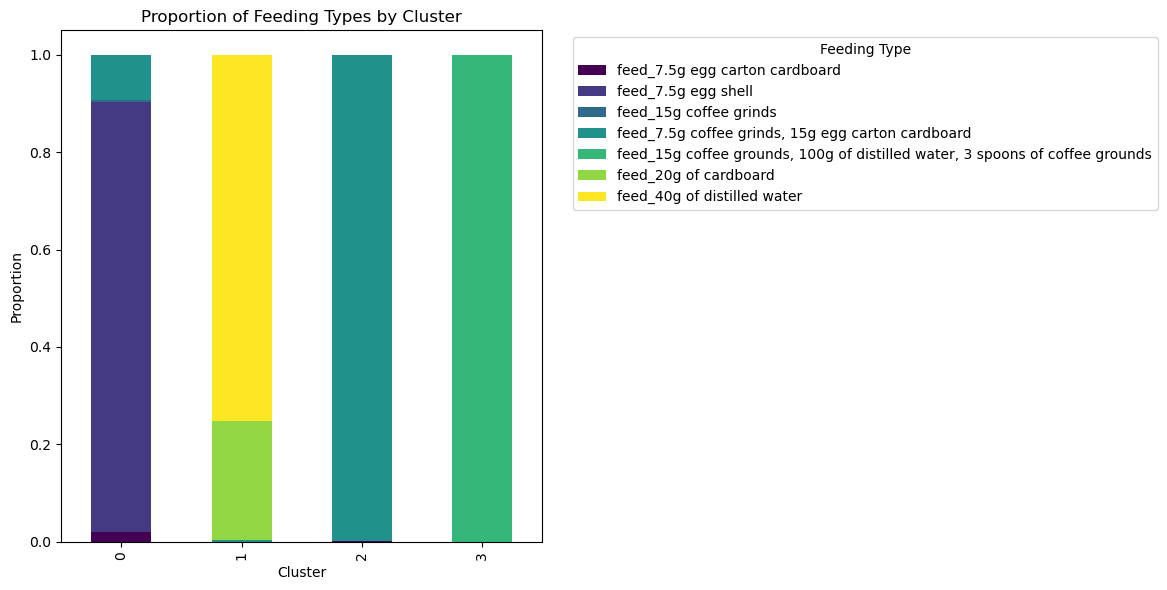

In [38]:
# Separate the feeding columns from the data (excluding 'Cluster')
feeding_columns = [col for col in data_cleaned.columns if 'feed_' in col]
data_feeding = data_cleaned[feeding_columns]

# Calculate the proportion of each feeding type within each cluster
feeding_proportions = data_cleaned.groupby('Cluster')[feeding_columns].mean()

# Plot the stacked bar plot
plt.figure(figsize=(12, 6))
feeding_proportions.plot(kind='bar', stacked=True, figsize=(12, 6), cmap="viridis")
plt.title('Proportion of Feeding Types by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Proportion')
plt.legend(title='Feeding Type', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust the legend position
plt.tight_layout()  # Adjust layout to make room for the legend
plt.show()

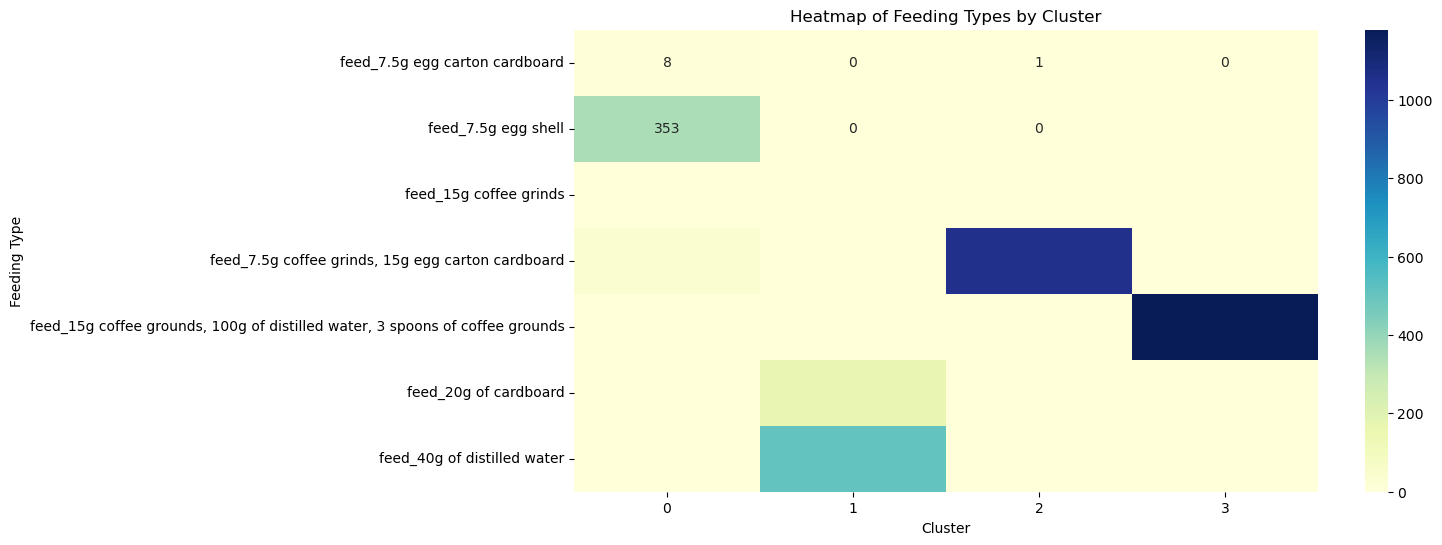

In [39]:
# Calculate the frequency of each feeding type within each cluster
feeding_counts = data_cleaned.groupby('Cluster')[feeding_columns].sum()

# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(feeding_counts.T, annot=True, fmt="d", cmap="YlGnBu")
plt.title('Heatmap of Feeding Types by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Feeding Type')
plt.show()

## Cluster Analysis and Detailed Insights

### Cluster 0

**Soil Parameters:**
- **EC (Electrical Conductivity):** 
  - Median value around 170, indicating moderate soil conductivity.
  - Narrow range of values suggesting consistent EC levels within this cluster.
- **Moisture:** 
  - Consistent values close to 1, implying high soil moisture content across the cluster.
- **Nitrogen:**
  - Median value around 50, with some outliers indicating occasional higher nitrogen content.
- **pH:**
  - Median value around 7, indicating neutral soil pH.
  - Some outliers with lower pH values, suggesting occasional soil acidity.
- **Phosphorus:**
  - Wide range of values with a median around 20, indicating variable phosphorus content.
- **Potassium:**
  - Median value around 60, showing moderate potassium levels.
- **Temperature:**
  - Median temperature around 27°C, indicating moderate soil temperature.

**Feeding Types:**
- Dominated by "feed_7.5g egg shell" with some presence of "feed_7.5g egg carton cardboard."
- Indicates a simpler feeding regime.

### Cluster 1

**Soil Parameters:**
- **EC:**
  - Slightly higher median EC value compared to Cluster 0.
  - Narrow range of values suggesting consistent EC levels.
- **Moisture:** 
  - Consistent values close to 1, indicating high soil moisture content.
- **Nitrogen:**
  - Median value around 75, indicating higher nitrogen content compared to Cluster 0.
- **pH:**
  - Median value slightly higher than Cluster 0, still neutral.
  - Wider variability, with occasional higher pH values.
- **Phosphorus:**
  - Median value around 80, showing higher phosphorus content.
- **Potassium:**
  - Higher median value around 80, indicating increased potassium levels.
- **Temperature:**
  - Slightly lower median temperature with a wider range, around 27°C.

**Feeding Types:**
- Predominantly "feed_40g of distilled water" with some presence of "feed_20g of cardboard."
- Indicates a mixture of simpler and intermediate feeding regimes.

### Cluster 2

**Soil Parameters:**
- **EC:**
  - Median value around 168, indicating lower soil conductivity.
  - Wider range of values suggesting more variability.
- **Moisture:** 
  - Consistent values close to 1, indicating high soil moisture content.
- **Nitrogen:**
  - Highest median value close to 100, indicating very high nitrogen content.
  - Lower variability, suggesting more consistent nitrogen levels.
- **pH:**
  - Median value around 7, similar to Cluster 0, indicating neutral pH.
- **Phosphorus:**
  - Higher phosphorus content with a median around 120.
- **Potassium:**
  - Highest median value around 100, indicating very high potassium levels.
- **Temperature:**
  - Higher median temperature around 30°C, suggesting warmer soil conditions.

**Feeding Types:**
- Almost exclusively consists of "feed_15g coffee grinds."
- Indicates a specialized feeding regime focusing on coffee grinds.

### Cluster 3

**Soil Parameters:**
- **EC:**
  - Highest variability in EC with a median value slightly below 172.
- **Moisture:** 
  - Consistent values close to 1, indicating high soil moisture content.
- **Nitrogen:**
  - High nitrogen values, slightly lower than Cluster 2, with wide variability.
- **pH:**
  - Highest variability with a median value around 9, indicating more alkaline conditions.
- **Phosphorus:**
  - High phosphorus values with a median around 100 but with wide variability.
- **Potassium:**
  - Similar potassium values to Cluster 1 but with more variability.
- **Temperature:**
  - Similar temperature to Cluster 0 but with higher variability, around 27°C.

**Feeding Types:**
- Mainly consists of "feed_15g coffee grounds, 100g of distilled water, 3 spoons of coffee grounds."
- Indicates a complex feeding regime with multiple components.

### Summary of Clusters
1. **Cluster 0:**
   - Moderate nutrient levels, neutral pH, moderate temperature.
   - Simple feeding types: egg shell and egg carton cardboard.

2. **Cluster 1:**
   - Higher nutrient levels (especially nitrogen), slightly higher pH variability.
   - Mixture of simpler and intermediate feeding types: distilled water and cardboard.

3. **Cluster 2:**
   - Highest nutrient levels (nitrogen, phosphorus, potassium), neutral pH, warmest temperature.
   - Specialized feeding type: coffee grinds.

4. **Cluster 3:**
   - High nutrient levels, highest pH variability, moderate temperature.
   - Complex feeding regime: multiple components including coffee grounds and distilled water.

These insights provide a detailed understanding of how different feeding regimes impact soil nutrient profiles and conditions, allowing for optimization of the vermicomposting process to achieve desired outcomes.
